In [138]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
import random
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [139]:
## downloading reuters dataset
nltk.download("reuters")

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\E14\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [140]:
## importing the reuters dataset
from nltk.corpus import reuters

In [141]:
## paths
SUMMARIES_PATH = Path("./summaries")

In [142]:
## creating necessary directories if they do not exist
if not os.path.exists(SUMMARIES_PATH):
    os.mkdir(SUMMARIES_PATH)

## Proprocessing and EDA

In [143]:
print(f"Reuters corpus has {len(reuters.fileids())} news articles")
print(f"Reuters corpus has {len(reuters.categories())} categories")

Reuters corpus has 10788 news articles
Reuters corpus has 90 categories


In [144]:
## getting documents in each
category_count_map = list()
for category in reuters.categories():
    docs_in_category = reuters.fileids(category)
    docs_count = len(docs_in_category)
    # category_count_map[category] = docs_count
    category_count_map.append((category, docs_count))

cat_doc_count_df=pd.DataFrame(category_count_map, columns=("category", " count"))
cat_doc_count_df

,category,count
0,acq,2369
1,alum,58
2,barley,51
3,bop,105
4,carcass,68
...,...,...
85,veg-oil,124
86,wheat,283
87,wpi,29
88,yen,59


In [145]:
## saving the category summary
cat_doc_count_df.to_csv(SUMMARIES_PATH/"category_count.csv", index=False)

In [146]:
def get_reuters_corpus_samples(sample_fraction=0.1, random_state=42):
    random.seed(random_state)        # for reproducibility

    # Collect samples while preserving category ratios
    data = []
    for category in reuters.categories():
        fileids = reuters.fileids(category)
        sample_size = max(1, int(len(fileids) * sample_fraction))
        sampled_ids = random.sample(fileids, sample_size)
        
        for fid in sampled_ids:
            data.append((category, fid))

    # Create DataFrame
    df = pd.DataFrame(data, columns=["category", "fileid"])

    return df

In [147]:
df = get_reuters_corpus_samples()

In [148]:
df

,category,fileid
0,acq,test/19297
1,acq,test/15995
2,acq,training/13085
3,acq,training/12053
4,acq,training/11477
...,...,...
1308,yen,training/9946
1309,yen,training/872
1310,zinc,training/7842
1311,zinc,training/14572


In [149]:
## prorocessing text
nltk.download("stopwords") ## downloading stopwords if not already there
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("wordnet")
nltk.download("omw-1.4")


stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    
    # Lowercase, remove stopwords, and lemmatize
    processed = [
        lemmatizer.lemmatize(token.lower()) 
        for token in tokens 
        if token.isalpha() and token.lower() not in stop_words
    ]
    return processed

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\E14\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\E14\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\E14\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\E14\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\E14\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [150]:
def get_tokens(x):
    fileid = x["fileid"]
    doc_raw = reuters.raw(fileid)
    return preprocess_text(doc_raw)

df["text_tokenized"] = df.apply(get_tokens, axis=1)

### Token count distribution

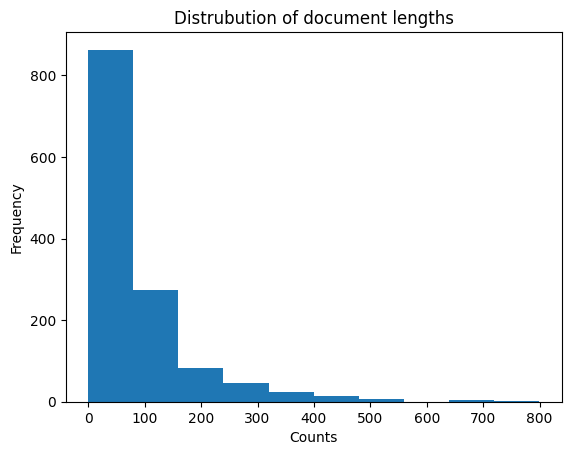

In [151]:
## showing distribution of documents lenghts
document_lengths = df["text_tokenized"].apply(len)

document_lengths.plot.hist()
plt.title("Distrubution of document lengths")
plt.xlabel("Counts")
plt.show()

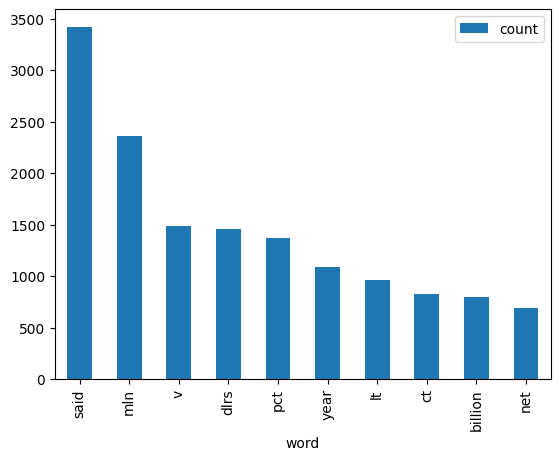

In [152]:
## getting top 10 frequent words
full_word_corpus = np.hstack(df["text_tokenized"])
words,counts = np.unique(full_word_corpus, return_counts=True)

word_count_df = pd.DataFrame({"word": words, "count":counts}).sort_values("count", ascending=False)
top_10_words = word_count_df.iloc[:10]
top_10_words.set_index("word").plot.bar()
plt.show()

In [153]:
## getting distrubition of the various parts of speech
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download('averaged_perceptron_tagger_eng')


pos_df = pd.DataFrame(nltk.pos_tag(full_word_corpus), columns=("word", "pos"))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\E14\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\E14\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\E14\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


## Information Extraction and Summarization

### POS Distribution

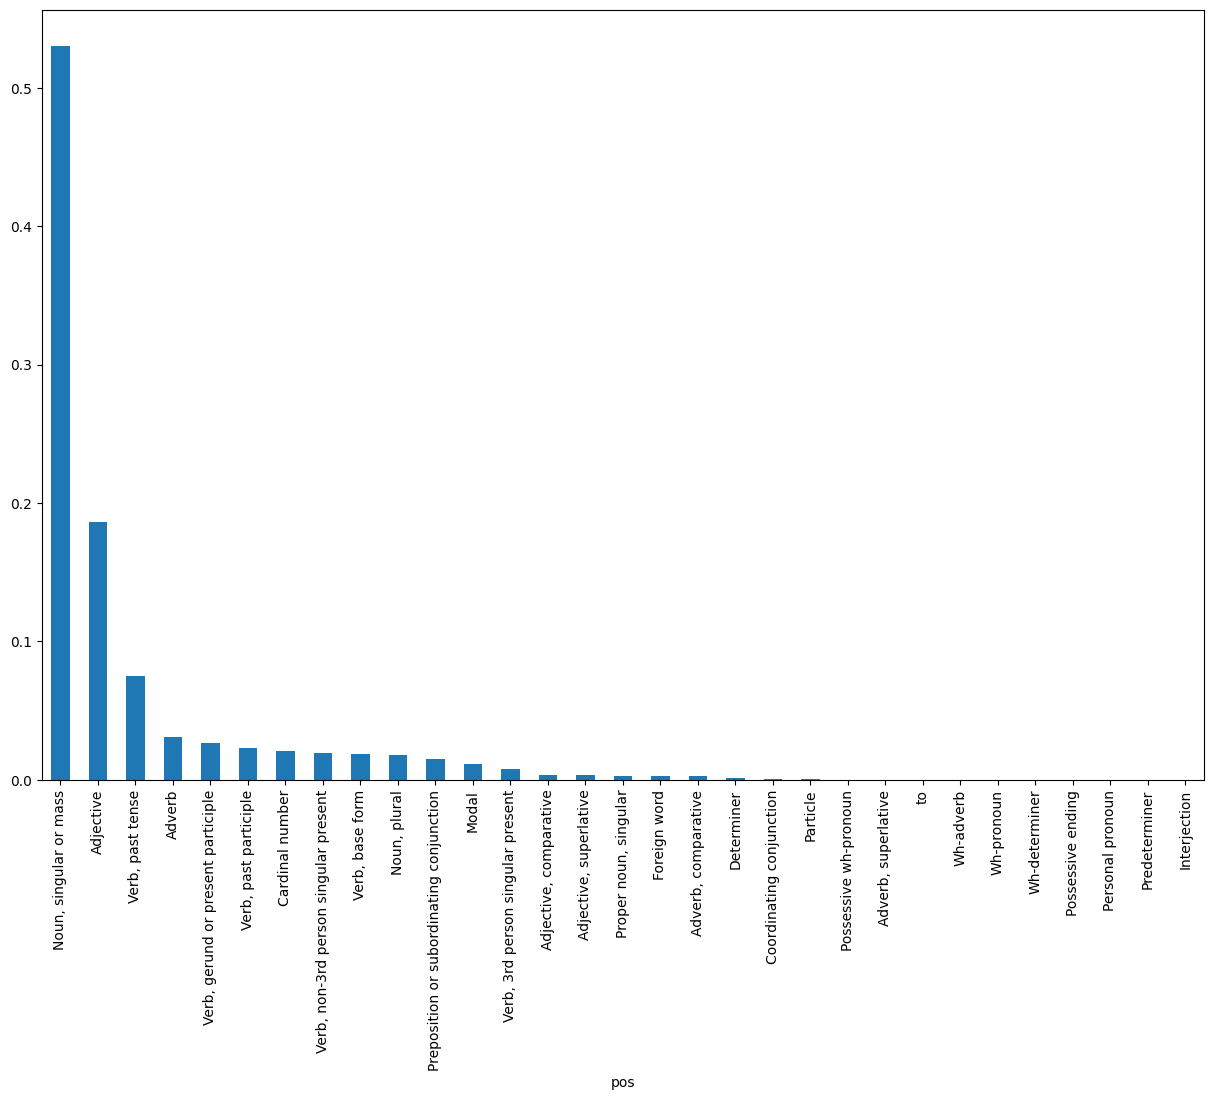

In [154]:
pos_counts = pos_df["pos"].value_counts(normalize=True)
pos_full_form = {
    "CC": "Coordinating conjunction",
    "CD": "Cardinal number",
    "DT": "Determiner",
    "EX": "Existential there",
    "FW": "Foreign word",
    "IN": "Preposition or subordinating conjunction",
    "JJ": "Adjective",
    "JJR": "Adjective, comparative",
    "JJS": "Adjective, superlative",
    "LS": "List item marker",
    "MD": "Modal",
    "NN": "Noun, singular or mass",
    "NNS": "Noun, plural",
    "NNP": "Proper noun, singular",
    "NNPS": "Proper noun, plural",
    "PDT": "Predeterminer",
    "POS": "Possessive ending",
    "PRP": "Personal pronoun",
    "PRP$": "Possessive pronoun",
    "RB": "Adverb",
    "RBR": "Adverb, comparative",
    "RBS": "Adverb, superlative",
    "RP": "Particle",
    "SYM": "Symbol",
    "TO": "to",
    "UH": "Interjection",
    "VB": "Verb, base form",
    "VBD": "Verb, past tense",
    "VBG": "Verb, gerund or present participle",
    "VBN": "Verb, past participle",
    "VBP": "Verb, non-3rd person singular present",
    "VBZ": "Verb, 3rd person singular present",
    "WDT": "Wh-determiner",
    "WP": "Wh-pronoun",
    "WP$": "Possessive wh-pronoun",
    "WRB": "Wh-adverb",
    ".": "Punctuation mark",
    ",": "Comma",
    ":": "Colon or ellipsis",
    "''": "Closing quotation mark",
    "``": "Opening quotation mark",
    "$": "Dollar sign",
    "#": "Pound sign"
}

pos_counts.index = pos_counts.index.map(pos_full_form)

plt.figure(figsize=(15,10))
pos_counts.plot.bar()
plt.show()

### TFIDF

In [155]:
def preprocess_for_tfidf(text):
    return " ".join(text)  # preprocess_text from earlier

preprocessed_docs = [preprocess_for_tfidf(doc) for doc in df["text_tokenized"]]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(preprocessed_docs)
feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df

,aa,aaa,ab,abandon,abandoned,abandoning,abastecimento,abastecimiento,abattoir,abboud,...,zimmer,zinc,zirconium,ziyang,zloty,zoladex,zollinger,zone,zorinsky,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.431287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.157944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### TFIDF Ranking for document #2

In [157]:
# Choose a document index
doc_index = 2
doc_tfidf = tfidf_matrix[doc_index].toarray()[0]

# Create DataFrame for ranking
doc2_rank_df = pd.DataFrame({
    "term": feature_names,
    "tfidf": doc_tfidf
})

# Sort by TF-IDF score
doc2_rank_df = doc2_rank_df.sort_values(by="tfidf", ascending=False)
doc2_rank_df.head(20)

,term,tfidf
7811,snyder,0.618510
1326,cenergy,0.618510
3003,exchange,0.150659
7490,sec,0.120627
6538,proposal,0.116994
7992,stake,0.110742
1590,common,0.106745
5764,offer,0.099293
3230,filing,0.091083
974,boost,0.088359
